In [46]:
!pip install imantics

In [47]:
import os
import cv2
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import imantics
from PIL import Image
from skimage.transform import resize
from sklearn.model_selection import train_test_split
%matplotlib inline

In [48]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
images_dir ='/content/drive/MyDrive/Xray/images_cut'
masks_dir = '/content/drive/MyDrive/Xray/labels_cut'

In [50]:
images_listdir = os.listdir(images_dir)
masks_listdir = os.listdir(masks_dir)
random_images = np.random.choice(images_listdir, size = 9, replace = False)

In [51]:
print(len(images_listdir))
print(len(masks_listdir))

100
100


In [52]:
image_size=512
input_image_size=(512,512)

In [53]:
def read_image(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (image_size, image_size))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [54]:
number=200

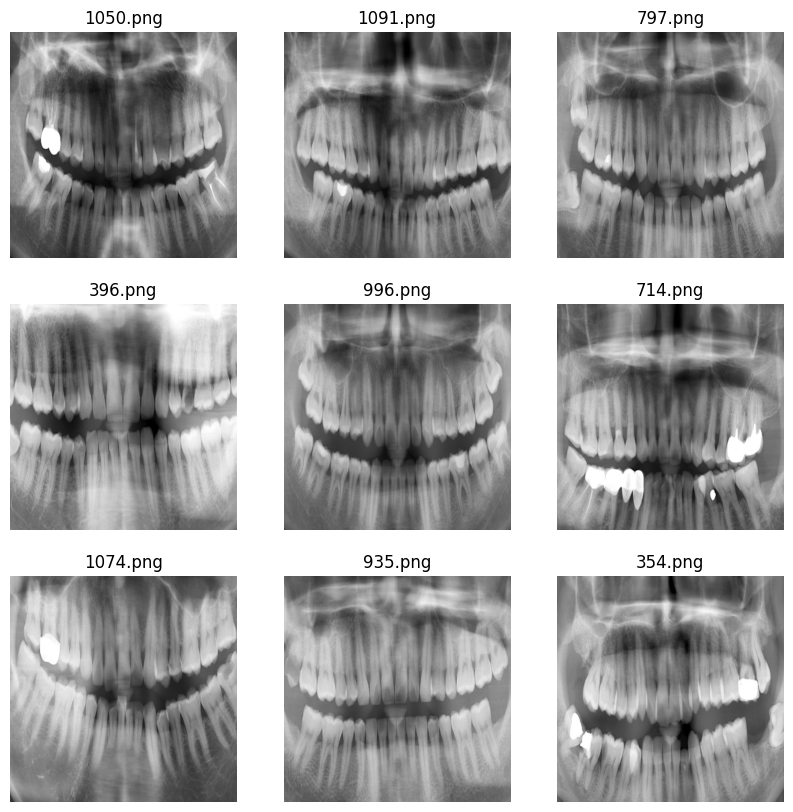

In [55]:
rows = 3
cols = 3
fig, ax = plt.subplots(rows, cols, figsize = (10,10))
for i, ax in enumerate(ax.flat):
    if i < len(random_images):
        img = read_image(f"{images_dir}/{random_images[i]}")
        ax.set_title(f"{random_images[i]}")
        ax.imshow(img)
        ax.axis('off')

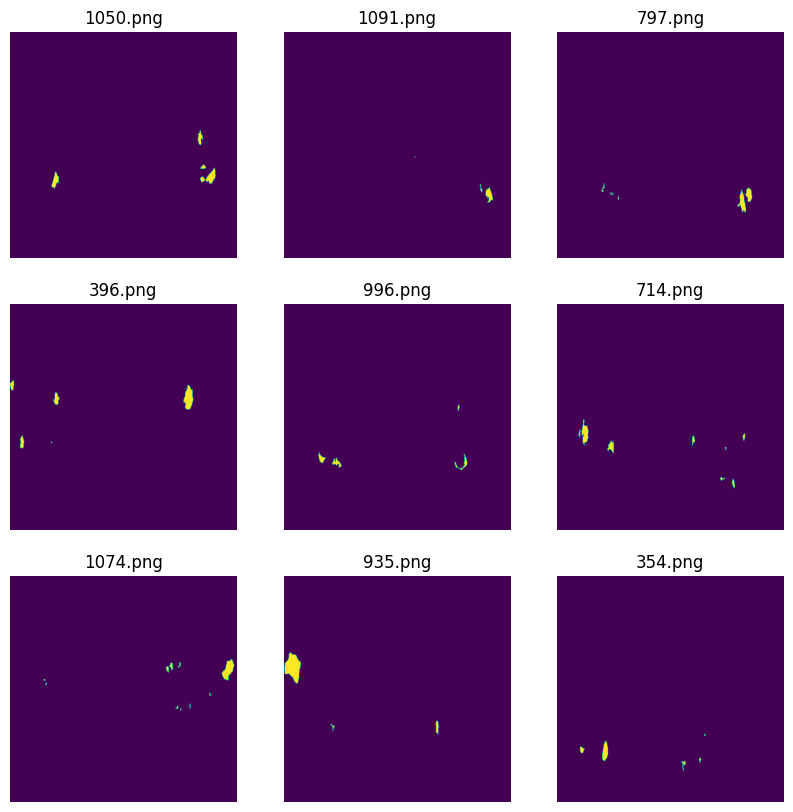

In [56]:
fig, ax = plt.subplots(rows, cols, figsize = (10,10))
for i, ax in enumerate(ax.flat):
    if i < len(random_images):
        file=random_images[i]
        if os.path.exists(os.path.join(masks_dir,file)):
            img = read_image(f"{masks_dir}/{file}")
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            ax.set_title(f"{random_images[i]}")
            ax.imshow(img)
            ax.axis('off')
        else:
            print('not exist')

In [57]:
MASKS=np.zeros((1,image_size, image_size, 1), dtype=bool)
IMAGES=np.zeros((1,image_size, image_size, 3),dtype=np.uint8)

for j,file in enumerate(images_listdir[0:number]):   ##the smaller, the faster
    try:
        image = read_image(f"{images_dir}/{file}")
        image_ex = np.expand_dims(image, axis=0)
        IMAGES = np.vstack([IMAGES, image_ex])
        mask = read_image(f"{masks_dir}/{file}")
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask = mask.reshape(512,512,1)
        mask_ex = np.expand_dims(mask, axis=0)
        MASKS = np.vstack([MASKS, mask_ex])
    except:
        print(file)
        continue

In [58]:
images=np.array(IMAGES)[1:number+1]
masks=np.array(MASKS)[1:number+1]
print(images.shape,masks.shape)

(100, 512, 512, 3) (100, 512, 512, 1)


In [59]:
images_train, images_test, masks_train, masks_test = train_test_split(
    images, masks, test_size=0.4, random_state=42)

In [60]:
print(len(images_train), len(masks_train))

60 60


In [61]:
def conv_block(input, num_filters):
    conv = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(input)
    conv = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Activation("relu")(conv)
    conv = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(conv)
    conv = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Activation("relu")(conv)
    return conv

def encoder_block(input, num_filters):
    skip = conv_block(input, num_filters)
    pool = tf.keras.layers.MaxPool2D((2,2))(skip)
    return skip, pool

def decoder_block(input, skip, num_filters):
    up_conv = tf.keras.layers.Conv2DTranspose(num_filters, (2,2), strides=2, padding="same")(input)
    conv = tf.keras.layers.Concatenate()([up_conv, skip])
    conv = conv_block(conv, num_filters)
    return conv

def Unet(input_shape):
    inputs = tf.keras.layers.Input(input_shape)

    skip1, pool1 = encoder_block(inputs, 64)
    skip2, pool2 = encoder_block(pool1, 128)
    skip3, pool3 = encoder_block(pool2, 256)
    skip4, pool4 = encoder_block(pool3, 512)

    bridge = conv_block(pool4, 1024)

    decode1 = decoder_block(bridge, skip4, 512)
    decode2 = decoder_block(decode1, skip3, 256)
    decode3 = decoder_block(decode2, skip2, 128)
    decode4 = decoder_block(decode3, skip1, 64)
    outputs = tf.keras.layers.Conv2D(1, 1, padding="same", activation="sigmoid")(decode4)
    model = tf.keras.models.Model(inputs, outputs, name="U-Net")
    return model

unet_model = Unet((512,512,3))
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#unet_model.summary()

In [62]:
unet_result = unet_model.fit(
    images_train, masks_train,
    validation_split = 0.2, batch_size = 4, epochs = 120)

Epoch 1/120
12/12 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.5829 - loss: -2.2289 - val_accuracy: 0.0027 - val_loss: -4097.6587
Epoch 2/120
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.7508 - loss: -9.6724 - val_accuracy: 0.0000e+00 - val_loss: -808453.2500
Epoch 3/120
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.7908 - loss: -13.3516 - val_accuracy: 0.0000e+00 - val_loss: -325456.6562
Epoch 4/120
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 987ms/step - accuracy: 0.8098 - loss: -16.8678 - val_accuracy: 3.1789e-07 - val_loss: -10798.1846
Epoch 5/120
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7332 - loss: -24.4086 - val_accuracy: 1.5036e-04 - val_loss: -185.4559
Epoch 6/120
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7829 - loss: -18.7586 - val_accuracy: 0.3183 - val_loss: -3.2402
Epoch 7/120
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.6919 - loss: -32.6218 - val_accuracy: 0.1420 - val_loss: -1639.7069
Epoch 8/120
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step 

In [63]:
# Evaluate the model on the test set
accuracy = unet_model.evaluate(images_test, masks_test)


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.9909 - loss: -156.6600


In [64]:

# print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


Test Accuracy: [-179.19882202148438, 0.9907835721969604]


In [65]:
def show_result(idx, og, unet, target, p):

    fig, axs = plt.subplots(1, 3, figsize=(12,12))
    axs[0].set_title("Original "+str(idx) )
    axs[0].imshow(og)
    axs[0].axis('off')

    axs[1].set_title("U-Net: p>"+str(p))
    axs[1].imshow(unet)
    axs[1].axis('off')

    axs[2].set_title("Ground Truth")
    axs[2].imshow(target)
    axs[2].axis('off')

    plt.show()

In [66]:
unet_predict = unet_model.predict(images_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 3s/step


In [67]:
len(images_test)

40

In [68]:
r1,r2,r3,r4=0.6,0.7,0.8,0.9

In [69]:
unet_predict1 = (unet_predict > r1).astype(np.uint8)
unet_predict2 = (unet_predict > r2).astype(np.uint8)
unet_predict3 = (unet_predict > r3).astype(np.uint8)
unet_predict4 = (unet_predict > r4).astype(np.uint8)

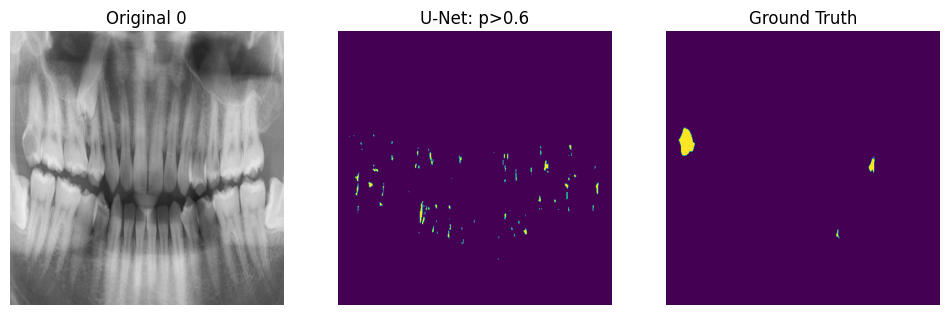

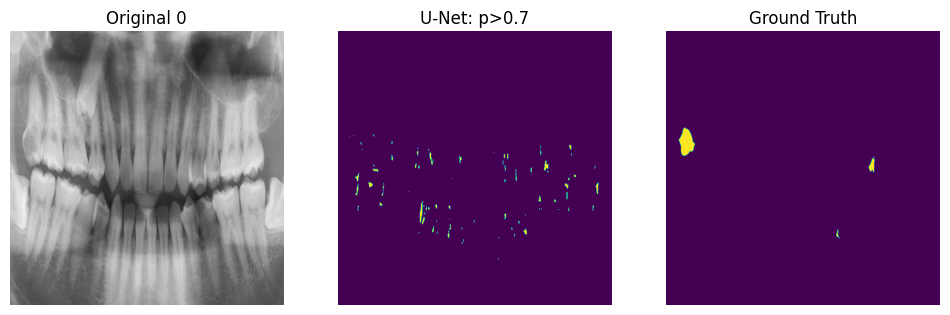

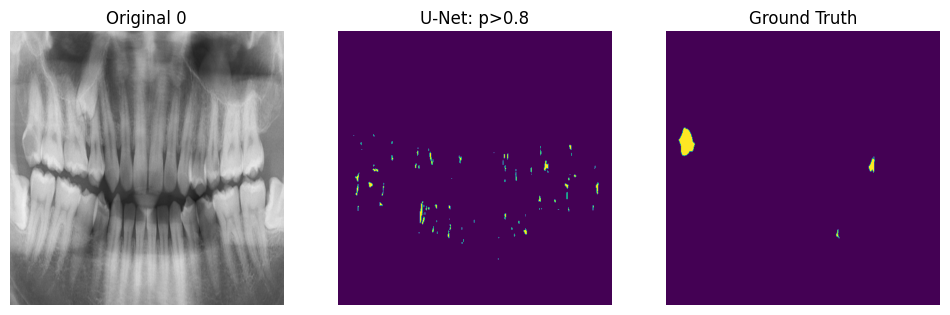

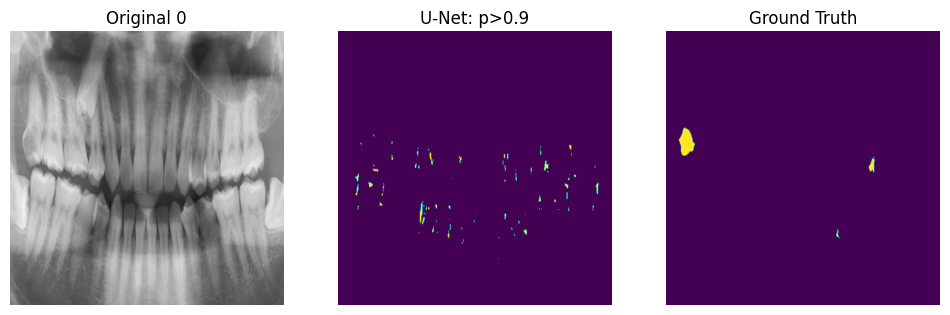

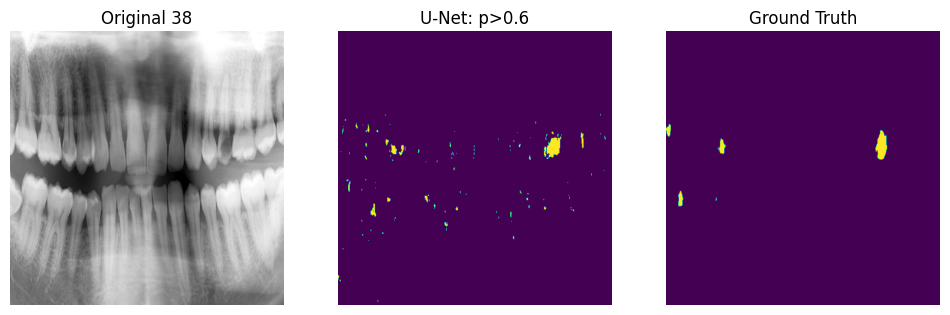

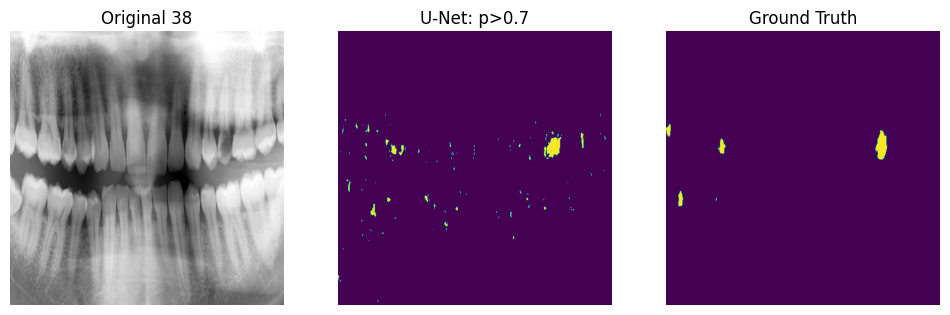

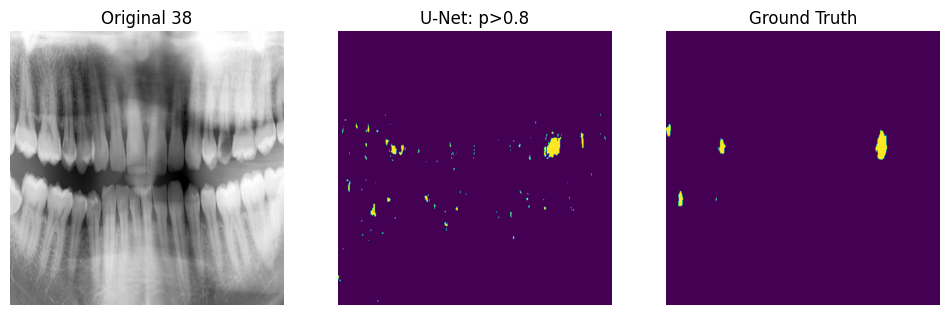

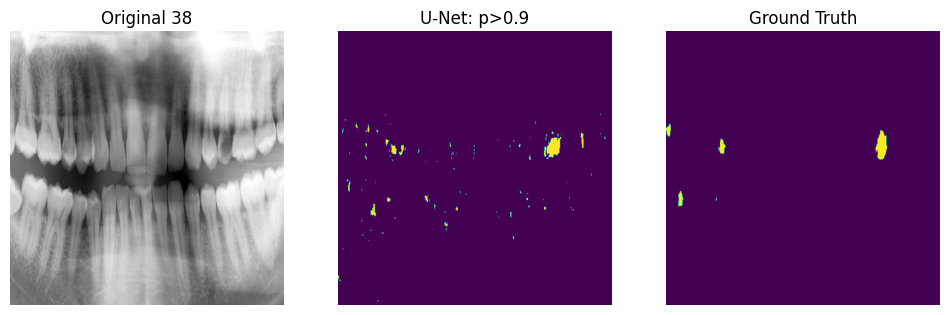

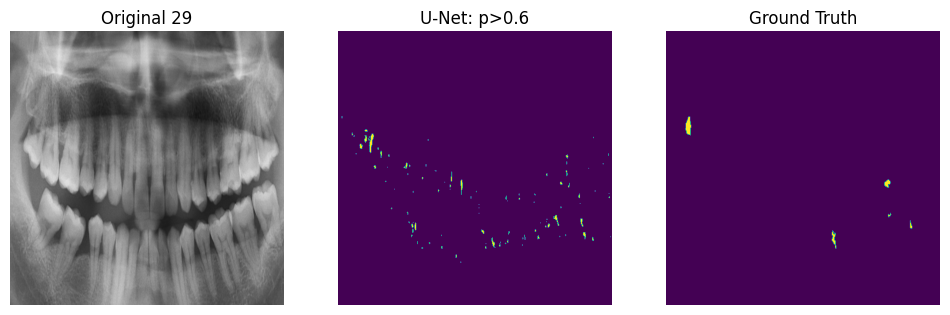

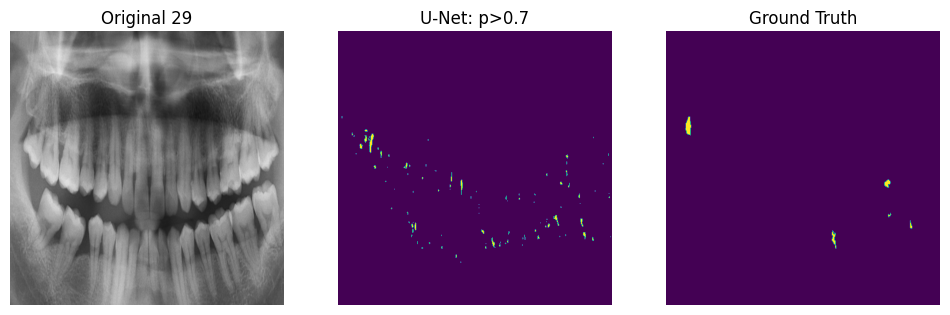

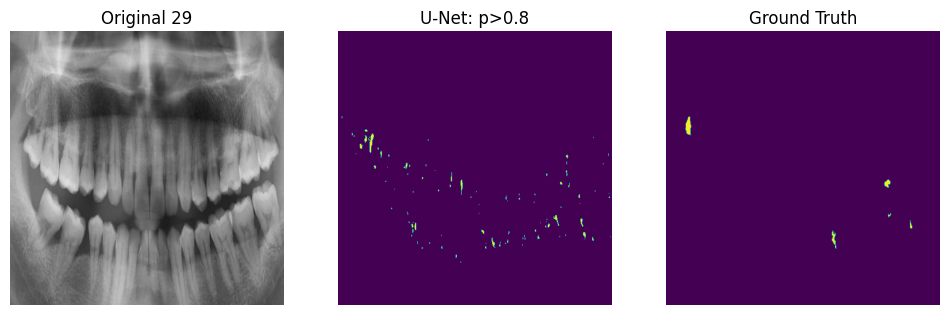

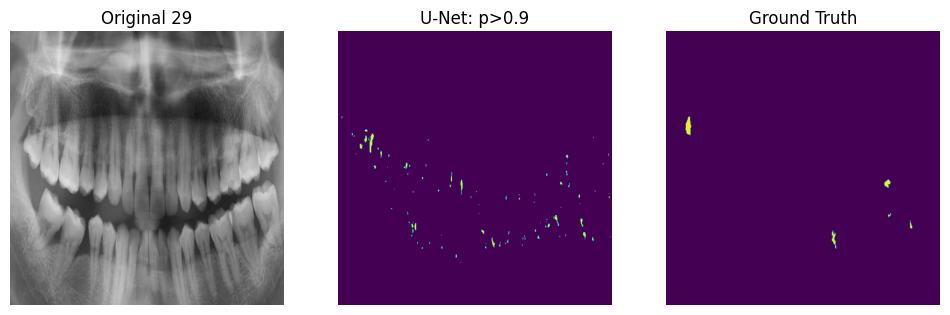

In [80]:
show_test_idx = random.sample(range(len(unet_predict)), 3)
for idx in show_test_idx:
    show_result(idx, images_test[idx], unet_predict1[idx], masks_test[idx], r1)
    show_result(idx, images_test[idx], unet_predict2[idx], masks_test[idx], r2)
    show_result(idx, images_test[idx], unet_predict3[idx], masks_test[idx], r3)
    show_result(idx, images_test[idx], unet_predict4[idx], masks_test[idx], r4)
    print()